In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

from tqdm import tqdm
tqdm.pandas()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIRETORIO_COHEBERT = "data"

DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/BERT_classificador/bert_base/" + DIRETORIO_COHEBERT

NOME_ARQUIVO_INPUT = 'bert_base_redacoes_cos_sim_texto_motivador_categoria.csv'

# 1. Setup colab GPU

In [4]:
import os

# Torna as operações CUDA síncronas para propósitos de debug
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Limpa cache da GPU
# torch.cuda.empty_cache()


In [5]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# 1.1 Attach torch to GPU

In [6]:
import torch
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


# 1.2 Install libraries

In [7]:
! pip install sklearn
! pip install -U sentence-transformers
! python -m spacy download pt_core_news_sm
! pip torch
! pip install --upgrade tensorflow h5py

import nltk
nltk.download('punkt')

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=9a5ab8fef8ef6759572ba7c35db602480a1f24aa8341b13094d29044239d2919
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 2. Load dataset pré-processado

---



In [8]:
df=pd.read_csv(f"{DIRETORIO_DRIVE}/{NOME_ARQUIVO_INPUT}")
df.info()
df=df[['redacao', 'texto_motivador', 'nota_competencia_2']]
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         2653 non-null   int64  
 1   redacao                                    2653 non-null   object 
 2   nota_competencia_2                         2653 non-null   int64  
 3   nota_geral                                 2653 non-null   int64  
 4   tema                                       2653 non-null   object 
 5   texto_motivador                            2653 non-null   object 
 6   categoria                                  2653 non-null   object 
 7   sentencas_redacao                          2653 non-null   object 
 8   sentencas_texto_motivador                  2653 non-null   object 
 9   qtd_sentencas_redacao                      2653 non-null   int64  
 10  qtd_sentencas_texto_moti

,redacao,texto_motivador,nota_competencia_2
1555,no que se diz respeito à temática do estigma a...,"texto i: a maior parte das pessoas, quando ouv...",120
493,"é inegável que, para alguns, o simples fato de...",feminicídio é o assassinato de uma mulher pela...,120
475,atualmente predomina-se um mundo moderno e te...,"""as fake news são mais do que simplesmente not...",120
1910,a violência urbana tornou-se um problema socia...,"frequentemente, conflitos armados entre polcia...",160
1291,é lamentável a sociedade chegar no âmbito de d...,"o presidente dos estados unidos, barack obama,...",120


# Discretiza notas em faixas de 0 a 5

In [9]:
def map_score_to_class(score):
    return score // 40

df['nota_competencia_2'] = df.nota_competencia_2.apply(map_score_to_class)

In [10]:
# Extrai redacoes, textos motivadores e notas para treinamento

redacoes = df.redacao.values
textos_motivadores = df.texto_motivador.values
notas = df.nota_competencia_2.values

# 3. Tokenização e preparação de textos para treinamento no BERTimbau

In [11]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForSequenceClassification  # Or BertForPreTraining for loading pretraining heads

model_name = 'neuralmind/bert-base-portuguese-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

# num_labels corresponde ao intervalo de notas possíveis na categoria 2 i.e. [0, 40, 80, 120, 160, 200], ou seja, 6.
bertimbau = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).cuda()

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3.1 Tamanho dos textos e Attention Mask

Redaçãoes e textos motivadores obviamente possuem tamanhos variáveis e existem duas formas do BERT lidar com isso:



1.   Textos devem ser truncados ou a técnica de *padding* deve ser aplicada para que os textos tenham um tamanho fixo `e.g. 300`
2.   Textos devem ser menores do que o limite máximo de `512` tokens



# 3.2 Tokenização de redações

In [12]:
# Tokenize todas as redações e realiza o mapeamento de tokens para os seus respectivos input_ids

r_input_ids = []
r_attention_masks = []

for redacao in redacoes:
    # `encode_plus` will:
    #   (1) Tokeniza redação.
    #   (2) Add `[CLS]` token no inicio do texto.
    #   (3) Add `[SEP]` token no fim do texto.
    #   (4) Mapeamento de tokens para seus IDs.
    #   (5) Padding `max_length`
    #   (6) Cria attention masks para os tokens do tipo [PAD].
    r_encoded_dict = tokenizer.encode_plus(
                        redacao,                      # Redação.
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 512,             # Pad redação.
                        padding = 'max_length',
                        return_attention_mask = True, # Constrói attn. masks.
                        return_tensors = 'pt',        # Retorna pytorch tensors.
                   )


    r_input_ids.append(r_encoded_dict['input_ids'])
    r_attention_masks.append(r_encoded_dict['attention_mask'])

# 3.3 Tokenização de textos motivadores

In [13]:
# Tokenize todas as redações e realiza o mapeamento de tokens para os seus respectivos input_ids

tm_input_ids = []
tm_attention_masks = []

for tm in textos_motivadores:
    # `encode_plus` will:
    #   (1) Tokeniza texto motivador.
    #   (2) Add `[CLS]` token no inicio do texto.
    #   (3) Add `[SEP]` token no fim do texto.
    #   (4) Mapeamento de tokens para seus IDs.
    #   (5) Padding `max_length`
    #   (6) Cria attention masks para os tokens do tipo [PAD].
    tm_encoded_dict = tokenizer.encode_plus(
                        tm,                           # Texto motivador
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 512,             # Pad redação.
                        padding = 'max_length',
                        return_attention_mask = True, # Constrói attn. masks.
                        return_tensors = 'pt',        # Retorna pytorch tensors.
                   )


    tm_input_ids.append(tm_encoded_dict['input_ids'])
    tm_attention_masks.append(tm_encoded_dict['attention_mask'])

# 4. Transforma inputs em torches

# 5. Divide datasets em treinamento, validação, e teste

In [14]:
notas = torch.tensor(notas)

tm_input_ids = torch.cat(tm_input_ids, dim=0)
tm_attention_masks = torch.cat(tm_attention_masks, dim=0)

r_input_ids = torch.cat(r_input_ids, dim=0)
r_attention_masks = torch.cat(r_attention_masks, dim=0)

In [15]:
notas = notas.to(device)

r_input_ids = r_input_ids.to(device)
tm_input_ids = tm_input_ids.to(device)

r_attention_masks = r_attention_masks.to(device)
tm_attention_masks = tm_attention_masks.to(device)

In [16]:
notas = notas.float()

r_input_ids = r_input_ids.long()
tm_input_ids = tm_input_ids.long()

r_attention_masks = r_attention_masks.float()
tm_attention_masks = tm_attention_masks.float()

notas = notas.long()

In [17]:
from torch.utils.data import Dataset, DataLoader

class PreTokenizedDataset(Dataset):
    def __init__(self, r_input_ids_list, r_attention_masks_list, tm_input_ids_list, tm_attention_masks_list, notas):
        self.r_input_ids_list = r_input_ids_list
        self.r_attention_masks_list = r_attention_masks_list
        self.tm_input_ids_list = tm_input_ids_list
        self.tm_attention_masks_list = tm_attention_masks_list
        self.notas = notas

    def __len__(self):
        return len(self.notas)

    def __getitem__(self, idx):
        return {
            'r_input_ids': self.r_input_ids_list[idx],
            'r_attention_mask': self.r_attention_masks_list[idx],
            'tm_input_ids': self.tm_input_ids_list[idx],
            'tm_attention_mask': self.tm_attention_masks_list[idx],
            'nota_competencia_2': self.notas[idx]
        }


In [18]:
BATCH_SIZE = 8

complete_dataset = PreTokenizedDataset(r_input_ids, r_attention_masks, tm_input_ids, tm_attention_masks, notas)
complete_dataloader = DataLoader(complete_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 6. Treinamento

# 6.1 Helper functions

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as pd
from sklearn.metrics import accuracy_score

In [20]:
import torch
from torch import nn

NUM_LABELS = 6 # (0, 40, 80, 120, 160, 200)
INPUT_FEATURE_SIZE = 768

class BertForEssayScoring(nn.Module):
    def __init__(self):
        super(BertForEssayScoring, self).__init__()
        self.bert_encoder = bertimbau
        self.classification_head = nn.Sequential(
            nn.Linear(2 * self.bert_encoder.config.hidden_size, 512), # 2 * para a concatenação
            nn.ReLU(),
            nn.Linear(512, NUM_LABELS)
        )

    def forward(self, r_input_ids, r_attention_masks, tm_input_ids, tm_attention_masks):
        r_outputs = self.bert_encoder(r_input_ids, r_attention_masks, output_hidden_states=True)
        r_class_label_output = r_outputs.hidden_states[-1][:,0,:]

        tm_outputs = self.bert_encoder(tm_input_ids, tm_attention_masks, output_hidden_states=True)
        tm_class_label_output = tm_outputs.hidden_states[-1][:,0,:]

        concatenated_output = torch.cat((r_class_label_output, tm_class_label_output), dim=-1)

        logits = self.classification_head(concatenated_output)
        return logits

model = BertForEssayScoring()
model.to(device)


BertForEssayScoring(
  (bert_encoder): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(29794, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_f

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(bertimbau.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (29794, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# 6.2 Fine tunning


*   Declara learning rate
*   Declara otimizador



# 6.2 Loop de treinamento

In [22]:
def eval_model(model, loss_function, test_dataloader, device):
    model = model.eval()

    total_eval_accuracy = []
    total_eval_loss = 0
    total_eval_f1 = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            batch_r_input_ids = batch['r_input_ids'].to(device)
            batch_r_attention_masks = batch['r_attention_mask'].to(device)
            batch_tm_input_ids = batch['tm_input_ids'].to(device)
            batch_tm_attention_masks = batch['tm_attention_mask'].to(device)
            batch_labels = batch['nota_competencia_2'].to(device)

            logits = model(
                r_input_ids=batch_r_input_ids,
                r_attention_masks=batch_r_attention_masks,
                tm_input_ids=batch_tm_input_ids,
                tm_attention_masks=batch_tm_attention_masks
            )

            loss = loss_function(logits, batch_labels)
            total_eval_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate the average loss over all batches
    avg_test_loss = total_eval_loss / len(test_dataloader)

    # Calculate the accuracy and F1 score using the aggregated predictions and labels
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_test_loss, accuracy, f1

In [23]:
import datetime

def format_time(elapsed):
  '''
    Takes time in seconds and returns a string hh:mm:ss
  '''

  elapsed_rounded = int(round(elapsed))

  return str(datetime.timedelta(seconds=elapsed_rounded))


In [24]:
import time
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
import numpy as np
import copy
import os

# Define the number of folds for cross-validation
NUM_FOLDS = 10  # You can adjust this number based on your dataset size and requirements.

overall_train_loss_values = []
overall_val_loss_values = []
overall_train_accuracy_values = []
overall_val_accuracy_values = []
overall_train_f1_values = []
overall_val_f1_values = []
all_fold_time = 0

def train_with_cross_validation(model, optimizer, scheduler, loss_function, epochs, dataset, device, save_path, clip_value=2, logging_interval=40):

    # Initialize the K-fold cross-validator
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

    loss_values = []
    val_loss_values = []
    accuracy_train_values = []
    accuracy_val_values = []
    f1_train_values = []
    f1_val_values = []
    global all_fold_time

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_f1 = float('inf')  # Initialize with a high number

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        fold_t0 = time.time()
        print(f"\n=================== Fold {fold + 1} / {NUM_FOLDS} ======================")

        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

        train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
        val_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

        assert max(train_indices) < len(dataset) and max(val_indices) < len(dataset)

        # Save current fold datasets
        folds_save_dir = os.path.join(save_path, f"00_LR_{str(LR).replace('-', '_')}")
        if not os.path.exists(folds_save_dir):
            os.makedirs(folds_save_dir)

        torch.save(train_indices, os.path.join(folds_save_dir, f'train_indices_fold_{fold+1}.pt'))
        torch.save(val_indices, os.path.join(folds_save_dir, f'val_indices_fold_{fold+1}.pt'))

        for epoch in range(epochs):

            epoch_start_time = time.time()
            fold_time = time.time()

            # Reset as losses for the current epoch
            total_loss = 0
            total_accuracy = 0
            total_f1 = 0

            # Put the model into training mode.
            model.train()

            for step, batch in enumerate(train_dataloader):
                # Unpack this training batch from our dataloader and copy each tensor to the GPU.
                batch_r_input_ids = batch['r_input_ids'].to(device)
                batch_r_attention_masks = batch['r_attention_mask'].to(device)
                batch_tm_input_ids = batch['tm_input_ids'].to(device)
                batch_tm_attention_masks = batch['tm_attention_mask'].to(device)
                batch_labels = batch['nota_competencia_2'].to(device)

                model.zero_grad()  # Clear any previously calculated gradients before performing a backward pass.
                optimizer.zero_grad()

                # Perform a forward pass. This will return logits.
                logits = model(
                    r_input_ids=batch_r_input_ids,
                    r_attention_masks=batch_r_attention_masks,
                    tm_input_ids=batch_tm_input_ids,
                    tm_attention_masks=batch_tm_attention_masks
                )

                # Calculate loss and accumulate the loss value.
                loss = loss_function(logits, batch_labels)
                total_loss += loss.item()

                # Perform a backward pass to calculate gradients.
                loss.backward()

                # Clip the norm of the gradients to prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                # Update parameters and the learning rate.
                optimizer.step()
                scheduler.step()

                # Convert logits to predicted class.
                preds = torch.argmax(logits, dim=1).flatten().to(torch.int64)

                # Calculate the accuracy and f1 score.
                accuracy = accuracy_score(batch_labels.cpu().numpy(), preds.cpu().numpy()) * 100
                f1 = f1_score(batch_labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')

                total_accuracy += accuracy
                total_f1 += f1

            # Report the final accuracy, f1, and loss for this training run.
            avg_train_accuracy = total_accuracy / len(train_dataloader)
            avg_train_f1 = total_f1 / len(train_dataloader)
            avg_train_loss = total_loss / len(train_dataloader)

            accuracy_train_values.append(avg_train_accuracy)
            f1_train_values.append(avg_train_f1)
            loss_values.append(avg_train_loss)

            # #======================================================
            # #                    Validation
            # #======================================================

            # Put the model in evaluation mode
            model.eval()

            # Tracking variables
            total_eval_accuracy = 0
            total_eval_loss = 0
            total_eval_f1 = 0

            # Evaluate data for one epoch.
            for batch in val_dataloader:
                # Unpack this validation batch from our dataloader and copy each tensor to the GPU.
                batch_r_input_ids = batch['r_input_ids'].to(device)
                batch_r_attention_masks = batch['r_attention_mask'].to(device)
                batch_tm_input_ids = batch['tm_input_ids'].to(device)
                batch_tm_attention_masks = batch['tm_attention_mask'].to(device)
                batch_labels = batch['nota_competencia_2'].to(device)

                with torch.no_grad():
                    # Perform a forward pass. This will return logits.
                    logits = model(
                        r_input_ids=batch_r_input_ids,
                        r_attention_masks=batch_r_attention_masks,
                        tm_input_ids=batch_tm_input_ids,
                        tm_attention_masks=batch_tm_attention_masks
                    )

                    # Calculate loss and accumulate the loss value.
                    loss = loss_function(logits, batch_labels)
                    total_eval_loss += loss.item()

                    # Convert logits to predicted class.
                    preds = torch.argmax(logits, dim=1).flatten().to(torch.int64)

                    # Calculate the accuracy and f1 score.
                    accuracy = accuracy_score(batch_labels.cpu().numpy(), preds.cpu().numpy()) * 100
                    f1 = f1_score(batch_labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')

                    total_eval_accuracy += accuracy
                    total_eval_f1 += f1

            # Report the final accuracy, f1, and loss for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
            avg_val_f1 = total_eval_f1 / len(val_dataloader)
            avg_val_loss = total_eval_loss / len(val_dataloader)

            if avg_val_f1 < best_val_f1:
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"New best model found at fold {fold + 1} with F1: {avg_val_f1}\n")

            accuracy_val_values.append(avg_val_accuracy)
            f1_val_values.append(avg_val_f1)
            val_loss_values.append(avg_val_loss)

            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            print(f"Epoch {epoch + 1}/{epochs} took: {format_time(epoch_time)}")

        # Measure how long this fold took.
        fold_time = format_time(time.time() - fold_t0)
        all_fold_time += time.time() - fold_t0

        print("================================")
        print("\nTraining performance")
        print(f"Accuracy: {accuracy_train_values[-1]:.2f}%")
        print(f"F1 Score: {f1_train_values[-1]:.2f}")
        print(f"Loss: {loss_values[-1]:.2f}")
        print("================================")
        print("\nValidation performance")
        print(f"Accuracy: {accuracy_val_values[-1]:.2f}")
        print(f"F1 Score: {f1_val_values[-1]:.2f}")
        print(f"Loss: {val_loss_values[-1]:.2f}")
        print(f"\nFold {fold + 1} / {NUM_FOLDS} took: {fold_time}")

        overall_train_loss_values.append(loss_values[-1])
        overall_train_accuracy_values.append(accuracy_train_values[-1])
        overall_train_f1_values.append(f1_train_values[-1])
        overall_val_loss_values.append(val_loss_values[-1])
        overall_val_accuracy_values.append(accuracy_val_values[-1])
        overall_val_f1_values.append(f1_val_values[-1])

    print(f"overall_train_loss_values: {overall_train_loss_values}")
    print(f"overall_val_loss_values: {overall_val_loss_values}")
    print(f"overall_train_accuracy_values: {overall_train_accuracy_values}")
    print(f"overall_val_accuracy_values: {overall_val_accuracy_values}")
    print(f"overall_train_f1_values: {overall_train_f1_values}")
    print(f"overall_val_f1_values: {overall_val_f1_values}")

    # Calculate overall average metrics
    avg_train_loss = np.mean(overall_train_loss_values)
    avg_val_loss = np.mean(overall_val_loss_values)
    avg_train_accuracy = np.mean(overall_train_accuracy_values)
    avg_val_accuracy = np.mean(overall_val_accuracy_values)
    avg_train_f1 = np.mean(overall_train_f1_values)
    avg_val_f1 = np.mean(overall_val_f1_values)

    print(f"\n================================ Training complete! ================================")
    print("Overall summary:")
    print(f"Average Training Loss: {avg_train_loss:.2f}")
    print(f"Average Validation Loss: {avg_val_loss:.2f}")
    print(f"Average Training Accuracy: {avg_train_accuracy:.2f}")
    print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}")
    print(f"Average Training F1 Score: {avg_train_f1:.2f}")
    print(f"Average Validation F1 Score: {avg_val_f1:.2f}")
    print(f"All folds took: {format_time(all_fold_time)}")
    print("Training complete!")

    # Load best model
    model.load_state_dict(best_model_wts)
    print(f"Best model was from fold with F1 score: {best_val_f1:.2f}")

    return model, overall_train_loss_values, overall_val_loss_values, overall_train_accuracy_values, overall_val_accuracy_values, overall_train_f1_values, overall_val_f1_values


In [42]:
from transformers import get_linear_schedule_with_warmup

LR = 2e-5 # recommended lrs -> 5e-5, 3e-5, 2e-5
optimizer = AdamW(bertimbau.parameters(), lr=LR, eps = 1e-8)

EPOCHS = 3 # O artigo do BERT recomenda de 2-4 epocas. Checar se 4 épocas não está causando over-fitting.

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(complete_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

loss_function = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation” (from [here](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#42-optimizer--learning-rate-scheduler)).

# Treinamento

In [26]:
save_dir = f"/content/drive/MyDrive/Colab Notebooks/BERT_classificador/bert_base/treinamentos/k-folds"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [27]:
model, avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy, avg_train_f1, avg_val_f1 = train_with_cross_validation(
    model, optimizer, scheduler, loss_function, EPOCHS, complete_dataset, device, save_dir, clip_value=2, logging_interval=40
)


=================== Fold 1 / 10 ======================
New best model found at fold 1 with F1: 0.487492042271454

Epoch 1/3 took: 0:02:29
New best model found at fold 1 with F1: 0.549824113794702

Epoch 2/3 took: 0:02:27
New best model found at fold 1 with F1: 0.560946651387828

Epoch 3/3 took: 0:02:27

Training performance
Accuracy: 67.41%
F1 Score: 0.63
Loss: 0.89

Validation performance
Accuracy: 58.82
F1 Score: 0.56
Loss: 1.05

Fold 1 / 10 took: 0:07:25

=================== Fold 2 / 10 ======================
New best model found at fold 2 with F1: 0.7301133915104502

Epoch 1/3 took: 0:02:27
New best model found at fold 2 with F1: 0.7255427170868346

Epoch 2/3 took: 0:02:27
New best model found at fold 2 with F1: 0.7317555810202867

Epoch 3/3 took: 0:02:27

Training performance
Accuracy: 72.13%
F1 Score: 0.68
Loss: 0.82

Validation performance
Accuracy: 76.84
F1 Score: 0.73
Loss: 0.70

Fold 2 / 10 took: 0:07:23

=================== Fold 3 / 10 ======================
New best model 

# 7.1 Plot resultados

In [28]:
import matplotlib.pyplot as plt

def plot_performance(train_loss, val_loss, train_accuracy, val_accuracy, train_f1, val_f1):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, 'b-', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'r-', label='Validation F1 Score')
    plt.title('Training & Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

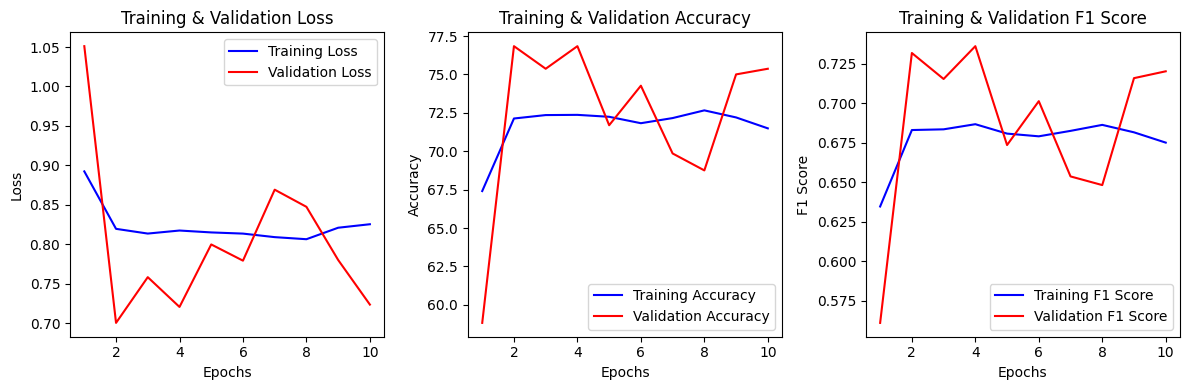

In [29]:
plot_performance(avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy, avg_train_f1, avg_val_f1)

# 8 Predictions

In [30]:
def predict(model, tokenizer, essay, auxiliary_text):

    model.to(device)

    essay_tokens = tokenizer(essay, return_tensors="pt", truncation=True, padding=True, max_length=500).to(device)
    auxiliary_tokens = tokenizer(auxiliary_text, return_tensors="pt", truncation=True, padding=True, max_length=500).to(device)

    # Ensure model is in evaluation mode
    model.eval()

    # No gradient computation needed during prediction
    with torch.no_grad():
        logits = model(essay_tokens['input_ids'], essay_tokens['attention_mask'], auxiliary_tokens['input_ids'], auxiliary_tokens['attention_mask'])
        prediction = torch.argmax(logits, dim=1)
    return prediction.item()

In [31]:
import random

rand = random.randrange(0, len(df))

redacao = df.loc[rand, 'redacao']
texto_motivador = df.loc[rand, 'texto_motivador']
nota = df.loc[rand, 'nota_competencia_2']

print(f'redacao: {redacao[:100]}')
print(f'texto motivador: {texto_motivador[:100]}')
print(f'classe: {nota // 40}')
print(f'nota: {nota}')

print('-' * 30)

pred = predict(model, tokenizer, redacao, texto_motivador)
print(f'classe pred: {pred}')
print(f'nota: {pred * 40}')

redacao: com o crescimento da população e da economia global nos dois últimos séculos, o mundo vem passando p
texto motivador: as mudanas climticas tornaram-se o bicho papo da atualidade. o cinema, por exemplo, j explorou os ch
classe: 0
nota: 2
------------------------------
classe pred: 2
nota: 80


# 9 Saves datasets indices for experiment reproduction

In [38]:
save_dir = f"/content/drive/MyDrive/Colab Notebooks/BERT_classificador/bert_base/treinamentos/k-folds"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [43]:
torch.save(model.state_dict(), f"{save_dir}/00_LR_{str(LR).replace('-', '_')}/bert_base_cls_tokens_lr_{str(LR)}_{EPOCHS}_epochs.json")

# Saves trained model

In [45]:
bert_classifier = BertForEssayScoring()
bert_classifier.load_state_dict(torch.load(f"{save_dir}/00_LR_{str(LR).replace('-', '_')}/bert_base_cls_tokens_lr_{str(LR)}_{EPOCHS}_epochs.json"))
bert_classifier.eval()

BertForEssayScoring(
  (bert_encoder): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(29794, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_f